# Classifying objects

In this notebook, we will use machine learning models to classify images of:
    
* Bottles
* Cartons
* Cups
* Cans
* Plastic film

## 1) Load packages

In [1]:
# Suppressing warnings to maintain clean output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import packages
%matplotlib inline
import os
import json
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 2) Load data for classification models

In [3]:
# Retrieve directory where we will get save processed data and features
parent_directory = os.path.abspath('../')
features_path = os.path.join(parent_directory,'data/features')
os.makedirs(features_path, exist_ok=True)

In the previous steps, we selected 1,561 samples (or annotations) to use in our first classification problem. The class labels for those samples are included in the dataset 'c1_info', which we load again below.

In [4]:
# Load the image labels and information
with np.load("{}/{}".format(features_path,"classification-labels.npz"), allow_pickle=True) as npz_file:
    # It's a dictionary-like object
    print(list(npz_file.keys()))

    # Load the arrays
    c1_info = npz_file["c1"]
    c1_info_colnames = npz_file["c1_colnames"]

c1_info = pd.DataFrame(c1_info, columns=c1_info_colnames)
c1_info

['c1', 's1', 'c1_colnames', 's1_colnames']


id image_id category_id c1_numlabel c1_label annotations_by_image
0        1        0           6         2.0   Bottle                    1
1        2        1          18         3.0   Carton                    2
2        3        1          14         3.0   Carton                    2
3        4        2           5         2.0   Bottle                    1
4        6        3           5         2.0   Bottle                    3
...    ...      ...         ...         ...      ...                  ...
1556  4776     1497           6         2.0   Bottle                    2
1557  4777     1497           6         2.0   Bottle                    2
1558  4779     1498          16         3.0   Carton                    1
1559  4782     1499          14         3.0   Carton                    2
1560  4783     1499           6         2.0   Bottle                    2

[1561 rows x 6 columns]

We also load the preprocessed images themselves, which are stored in a 4-dimensional numpy array 'c1_images'.

In [5]:
# Load the processed (cropped+framed) images
with np.load("{}/{}/{}".format(features_path,"widen_param_0.05","classification-images.npz"), allow_pickle=True) as npz_file:
    # Print the keys
    print(list(npz_file.keys()))

    # Load the arrays
    c1_images = npz_file["c1"]

['c1', 's1', 's1_masks']


We can see from the pie chart below that our original sample was unbalanced: the most frequent cateogory, plastic film (29%), has more than twice the number of samples as the least common category, cups (12%).

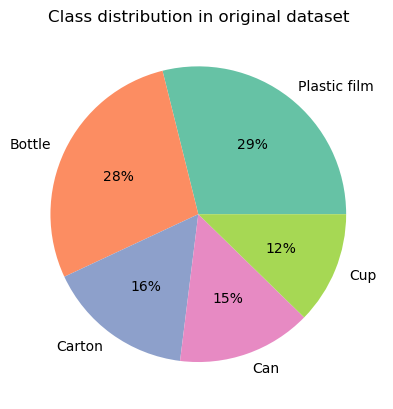

In [6]:
# Pie chart
piecolors = sns.color_palette('Set2',5)
plt.pie(c1_info.c1_label.value_counts(normalize=False), labels = c1_info.c1_label.value_counts(normalize=False).index, colors = piecolors, autopct='%.0f%%')
plt.title("Class distribution in original dataset")
plt.show()

## 3) Extract features

We use a pre-trained model, ResNet50V2, to create features that we will use in our machine learning models. ResNet50V2 is a deep convolutional neural network architecture used for image classification. This model was trained on the ImageNet dataset, which contains over 1 million images from [1,000 different image categories](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/). It has a top-1 accuracy of 76.0% on those classes.

This dataset includes a wide variety of images, such as animals, objects and people. Looking at the 1,000 categories included in ImageNet we can see that ResNet50V2 has already been trained to detect some of our classes, such as cans and bottles. Therefore, we expect it to perform well on our selected sample of images.

In [7]:
# Import tensorflow
import tensorflow as tf
import tensorflow_hub as hub

2024-05-11 11:29:26.087573: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


First, we check that our images have the required shape of 224x224 pixels, and we rescale the values for each pixel to the 0-1 range.

In [8]:
# Rescale array of images
c1_data_processed = c1_images*1./255.

In [9]:
# Feature extractor
feature_extractor_layer = hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4",
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=(224, 224, 3)) # define the input image shape

2024-05-11 11:29:28.730270: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Then, we generate our 2,048 features in batches of 10 images to avoid overwhelming our runtime's memory.

In [10]:
# Initialize an empty DataFrame to store features
c1_features = pd.DataFrame()

# Generate high-level features in batches
batch_size = 10
num_samples = c1_data_processed.shape[0]

for i in range(0, num_samples, batch_size):
    batch_data = c1_data_processed[i:i+batch_size]
    batch_features = feature_extractor_layer(batch_data).numpy()
    batch_features_df = pd.DataFrame(batch_features)
    
    if c1_features.empty:
        c1_features = batch_features_df
    else:
        c1_features = pd.concat([c1_features, batch_features_df])

# Reset index
c1_features.reset_index(drop=True, inplace=True)

Then, we add our class labels (in string and numeric format) back into the features dataset.

In [11]:
# Create training dataframe with features from ResNet50V2
c1_features.reset_index(drop=True,inplace=True)
c1_features.columns = c1_features.columns+1
c1_features = c1_features.add_prefix('feat_')

# Add variables
c1_features["annotation_id"] = c1_info["id"].copy()
c1_features["c1_label"] = c1_info["c1_label"].copy()
c1_features["c1_numlabel"] = c1_info["c1_numlabel"].copy()
c1_features = c1_features[c1_features.columns[::-1]]

#I nspect first few rows
c1_features.head(10)

c1_numlabel c1_label annotation_id  feat_2048  feat_2047  feat_2046  \
0         2.0   Bottle             1   0.000000   0.050308   0.489720   
1         3.0   Carton             2   0.016749   0.402603   0.082591   
2         3.0   Carton             3   0.187111   0.730265   0.017274   
3         2.0   Bottle             4   0.052835   0.000000   0.000000   
4         2.0   Bottle             6   0.004975   0.008609   0.077124   
5         2.0   Bottle             7   2.988679   0.241006   0.000000   
6         4.0      Can             9   0.017171   0.242250   0.114890   
7         4.0      Can            10   0.334378   0.069231   2.281562   
8         2.0   Bottle            13   0.169037   0.300295   0.300800   
9         2.0   Bottle            18   0.619309   0.737272   0.533513   

   feat_2045  feat_2044  feat_2043  feat_2042  ...   feat_10    feat_9  \
0   0.000000   0.032107   0.124284   0.000000  ...  2.571053  5.334683   
1   0.000000   0.029750   0.000000   0.000000  ...  0.042408  1.066764   
2   0.000000   0.000000   0.086928   0.000000  ...  0.011163  0.628070   
3   0.000000   0.279649   0.000000   0.000000  ...  0.004448  0.320454   
4   0.000000   0.341330   0.890142   0.000000  ...  0.727989  0.731481   
5   0.286299   0.158813   0.265916   0.000000  ...  0.000000  0.000000   
6   0.000000   0.086534   0.000000   0.003143  ...  0.896433  1.558552   
7   0.000000   0.000000   0.586581   0.004220  ...  0.371993  1.435410   
8   0.000000   0.000000   0.000000   0.000000  ...  0.216905  1.165062   
9   0.000000   0.269416   0.000000   0.000607  ...  0.000000  0.279992   

     feat_8    feat_7    feat_6    feat_5    feat_4    feat_3    feat_2  \
0  0.000000  0.792219  0.000000  0.080972  0.052082  0.000000  0.000000   
1  0.391926  0.005017  0.000000  0.000000  0.000000  0.095207  0.000000   
2  2.314357  0.006719  0.000000  0.000000  0.000000  0.054957  0.000000   
3  0.000000  0.372669  0.000000  0.126056  0.023610  0.000000  0.064648   
4  0.387769  0.143636  0.000000  0.017649  0.011170  0.051558  1.469814   
5  0.055434  0.357544  0.000000  0.078873  0.227037  0.127127  0.314141   
6  0.034449  0.882568  0.000000  0.323684  0.757865  0.049998  0.345090   
7  0.648124  2.793521  0.000000  1.819340  0.000000  0.000000  0.000000   
8  0.000000  0.164491  0.000000  0.498832  0.222087  0.000000  0.000000   
9  0.000000  0.508029  0.005348  0.623931  0.049481  0.000000  0.264277   

     feat_1  
0  0.105036  
1  0.123031  
2  3.062518  
3  0.554045  
4  0.000000  
5  0.037348  
6  0.092474  
7  0.573282  
8  2.758739  
9  0.094424  

[10 rows x 2051 columns]

## 4) Visualize the data

Now, let's visualize the samples included in our classification problem to check that they are labelled properly and have been resized in the way we expected.

We notice that the pictred objects have been subjected to a fair amount of 'wear and tear', with many cans in the wild having been crushed, for example. If ResNet50V2 was trained on a 'cleaner' set of images (e.g. cans on a shelf in a shop) then it might not classify these objects as accurately.

In [12]:
from random import sample

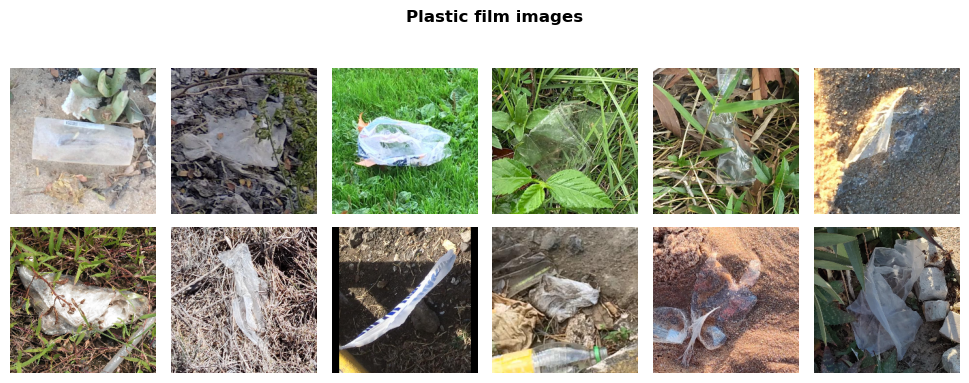

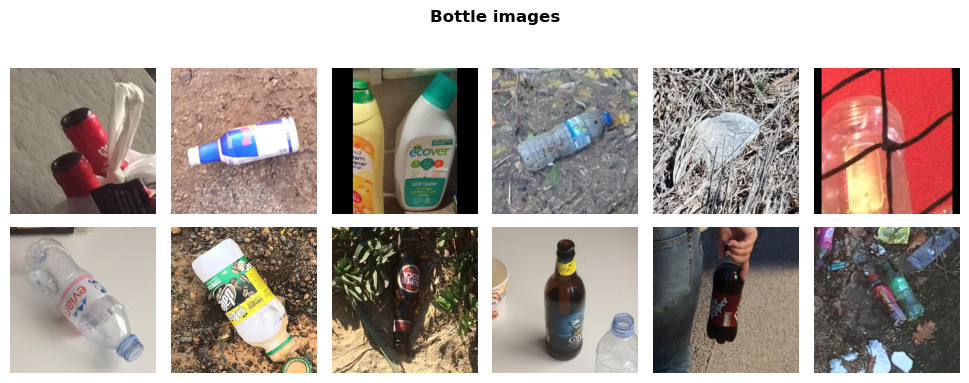

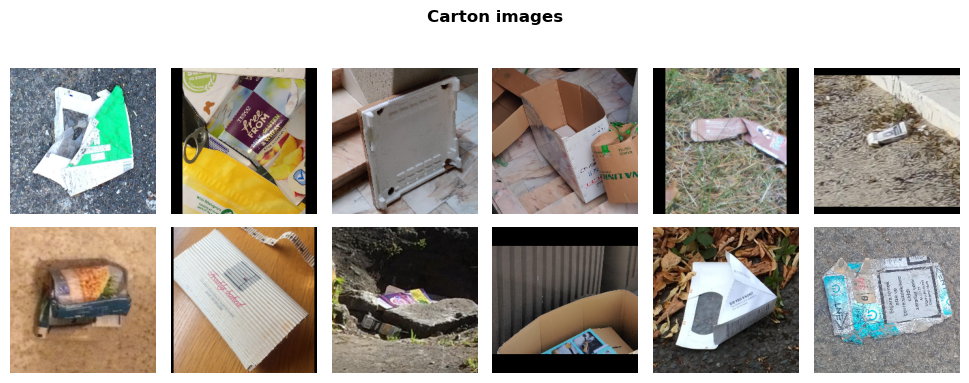

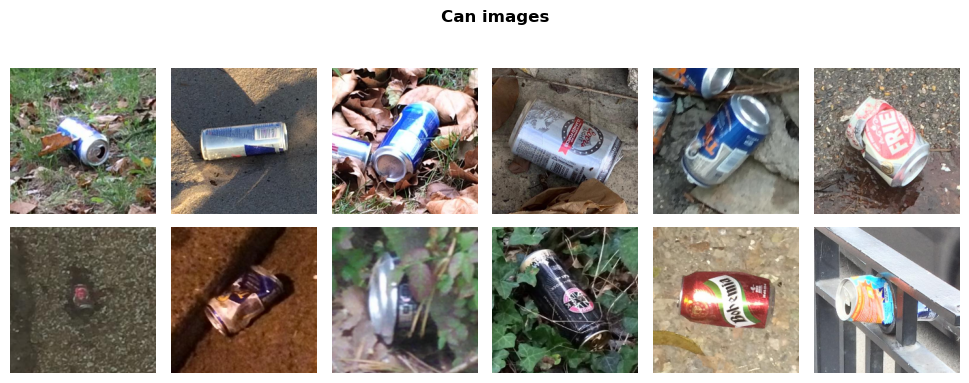

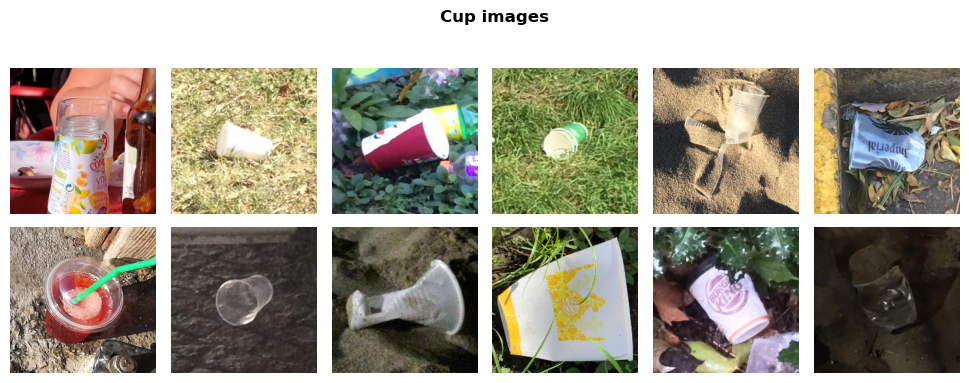

In [13]:
# Plotting function:
def plot_images_by_label(features, images, label, num_samples=12, nrows=2, ncols=6, figsize=(10, 4)):
    annotations_samples = sample(list(features.index[features.c1_label == label]), num_samples)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)

    for (annotindex, ax) in zip(annotations_samples, axes.flatten()):
        ax.imshow(images[annotindex, :, :, :])
        ax.set_axis_off()

    fig.suptitle(f"{label} images", fontsize=12, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 0.98, 0.98])
    plt.show()

# Example usage:
labels = ["Plastic film", "Bottle", "Carton", "Can", "Cup"]
for label in labels:
    plot_images_by_label(c1_features, c1_images, label=label)

## 5) Split out the testing set

After having balanced our dataset, we split it into a training/validation set (80%) and a testing set (20%). We choose to combine the training and validation set into one, because we will be applying 5-fold cross validation on the combined set later on.

In [14]:
# Separate features from labels
X = c1_features.drop(["c1_label","c1_numlabel","annotation_id"], axis=1)
ylab = c1_features["c1_label"]

In [15]:
# Split out data into a test test, and a training/validation set
from sklearn.model_selection import train_test_split

# Split data into training/validation and test sets
X_trainval, X_test, ylab_trainval, ylab_test = train_test_split(X, ylab, test_size=0.2, random_state=8, stratify=ylab)

# Concatenate features and labels for training/validation set
c1_trainval = pd.concat([ylab_trainval, X_trainval], axis=1)

# Convert to NumPy arrays
X_trainval, X_test = X_trainval.values, X_test.values
ylab_trainval, ylab_test = ylab_trainval.values, ylab_test.values

# Print shapes
print("X_trainval: {}, ylab_trainval: {}".format(X_trainval.shape, ylab_trainval.shape))
print("X_test: {}, ylab_test: {}".format(X_test.shape, ylab_test.shape))

X_trainval: (1248, 2048), ylab_trainval: (1248,)
X_test: (313, 2048), ylab_test: (313,)


We visualize the class distribution of the training/validation and testing sets and we are satisfied that these two samples are now balanced.

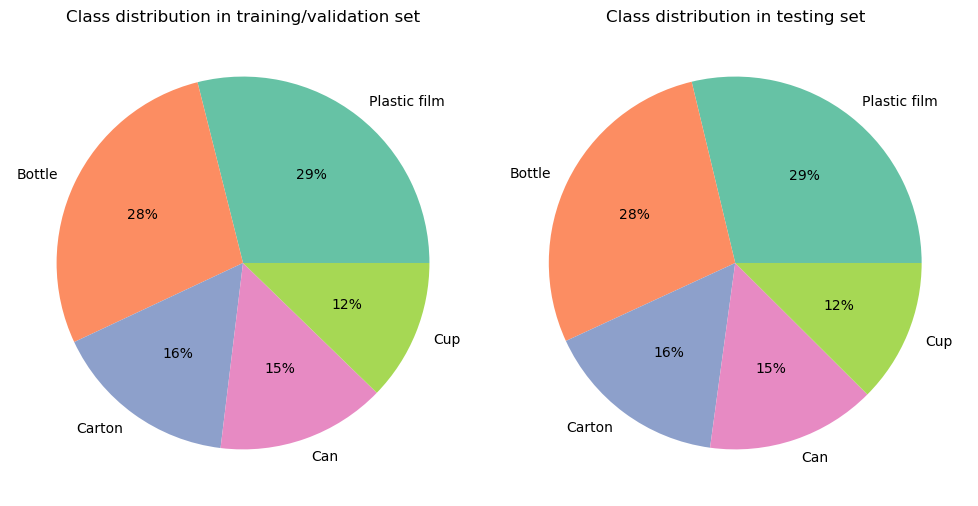

In [16]:
# Set the default figure size and enable automatic layout adjustment
plt.rcParams["figure.figsize"] = [10,5]
plt.rcParams["figure.autolayout"] = True

# Create subplots with pie charts for class distribution in training/validation set and testing set
plt.subplot(1, 2, 1)  # Subplot 1
plt.pie(pd.Series(ylab_trainval).value_counts(normalize=False), labels=pd.Series(ylab_trainval).value_counts(normalize=False).index, colors=piecolors, autopct='%.0f%%')
plt.title("Class distribution in training/validation set")  # Title for subplot 1

plt.subplot(1, 2, 2)  # Subplot 2
plt.pie(pd.Series(ylab_test).value_counts(normalize=False), labels=pd.Series(ylab_test).value_counts(normalize=False).index, colors=piecolors, autopct='%.0f%%')
plt.title("Class distribution in testing set")  # Title for subplot 2

plt.show()  # Display the subplots

# Restore the default plot settings
plt.rcParams.update(plt.rcParamsDefault)

## 6) Feature analysis and correlations

Next, we will run some exploratory data analysis on the 2,048 features created by the ResNet50V2 model.

In [17]:
# Convert the features to numeric
feature_column_names = c1_trainval.columns[c1_trainval.columns.str.startswith('feat')]
c1_trainval[feature_column_names] = c1_trainval[feature_column_names].apply(pd.to_numeric)

We can see that there are no missing values in these features and that the minimum value for all features is zero.

In [18]:
c1_trainval.describe()

feat_2048    feat_2047    feat_2046    feat_2045    feat_2044  \
count  1248.000000  1248.000000  1248.000000  1248.000000  1248.000000   
mean      0.451978     0.231683     0.343633     0.122529     0.338218   
std       0.766765     0.404592     0.577592     0.358983     0.726945   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000670     0.000000     0.007846     0.000000     0.000000   
50%       0.123543     0.061729     0.121769     0.000000     0.070770   
75%       0.538965     0.267729     0.435903     0.077762     0.312047   
max       6.213696     3.980013     5.498462     4.189203     8.583284   

         feat_2043    feat_2042    feat_2041    feat_2040    feat_2039  ...  \
count  1248.000000  1248.000000  1248.000000  1248.000000  1248.000000  ...   
mean      0.312336     0.001098     2.216229     0.796871     0.474547  ...   
std       0.628828     0.002917     2.039655     1.398666     1.133820  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.000000     0.000000     0.691894     0.010923     0.000000  ...   
50%       0.062755     0.000000     1.634952     0.189615     0.056342  ...   
75%       0.346840     0.000610     3.204142     0.913735     0.429925  ...   
max       6.736434     0.029176    15.936411     9.595291    12.763852  ...   

           feat_10       feat_9       feat_8       feat_7       feat_6  \
count  1248.000000  1248.000000  1248.000000  1248.000000  1248.000000   
mean      0.177344     0.416154     0.276357     0.957136     0.000663   
std       0.461448     0.637247     0.576075     1.346622     0.003544   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.027791     0.000000     0.093078     0.000000   
50%       0.008342     0.184455     0.049514     0.432297     0.000000   
75%       0.128479     0.561800     0.297340     1.312373     0.000000   
max       6.208887     7.715568     5.775364    12.631099     0.049578   

            feat_5       feat_4       feat_3       feat_2       feat_1  
count  1248.000000  1248.000000  1248.000000  1248.000000  1248.000000  
mean      0.306416     0.110318     0.114072     0.223051     0.503617  
std       0.558966     0.258142     0.302112     0.393936     0.732686  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.028523  
50%       0.083022     0.004946     0.012953     0.069591     0.221392  
75%       0.365314     0.096081     0.088390     0.279171     0.632879  
max       5.243632     2.441785     3.103780     5.219572     5.354151  

[8 rows x 2048 columns]

The maximum value for the 2,048 features goes up to 30 for some features. Therefore, there is some variation in the range of our features. The 2,048 features often have a value of zero. In fact, from below, we can see that about 24% of features are majority-zero.

The heatmaps below diplay the values of those features for each class. We can see that some features (vertical lines) are more active in some classes compared to others, with consistently higher values across all samples.

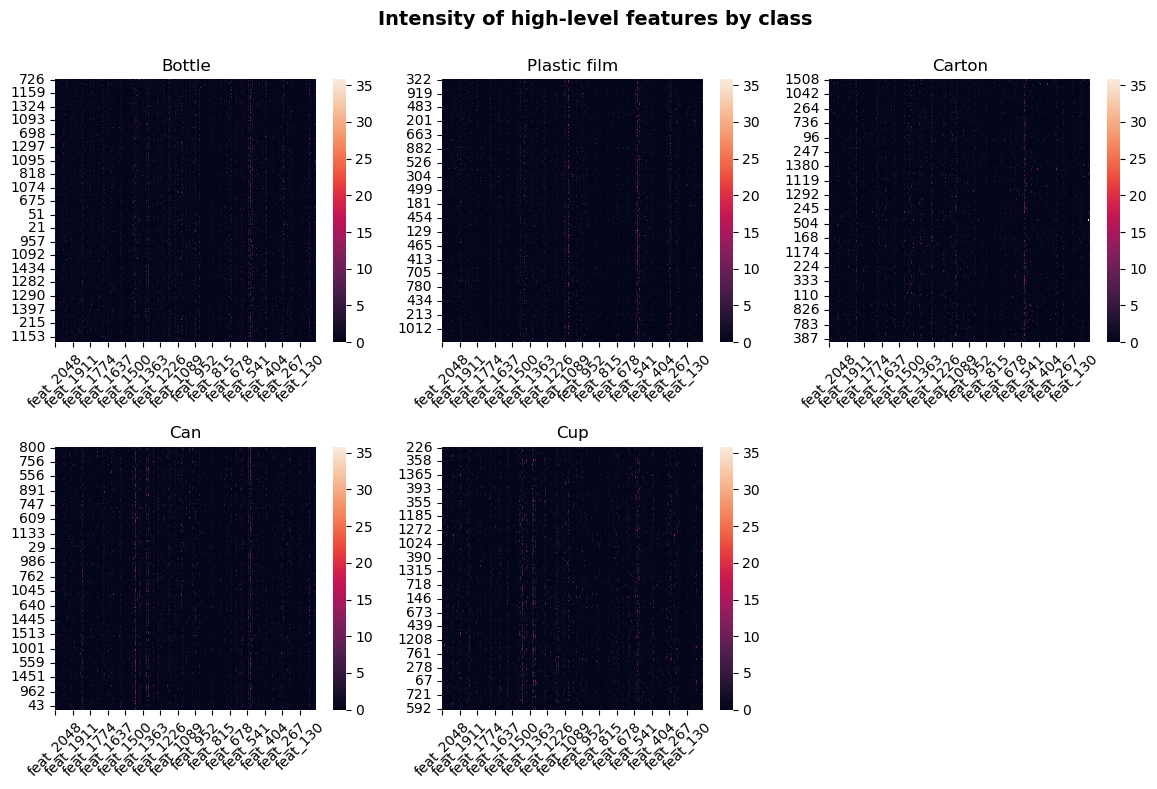

In [19]:
# Calculate the minimum and maximum values across all features for setting the color range
minrange = np.min(c1_trainval.describe().loc["min", :])
maxrange = np.max(c1_trainval.describe().loc["max", :])

# Create a grid of subplots for each class
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Iterate over each class and its corresponding axis in the subplot grid
for (var, ax) in zip(['Bottle', 'Plastic film', 'Carton', 'Can', 'Cup'], axes.flatten()):
    # Create a heatmap for the features of the current class
    sns.heatmap(ax=ax, data=c1_trainval.loc[c1_trainval.c1_label == var, c1_trainval.columns.str.startswith("feat")], vmin=minrange, vmax=maxrange)
    # Set the title for the current subplot with the class name
    ax.set_title(var)
    # Rotate x-axis labels for better readability and adjust their size
    ax.tick_params(axis='x', labelrotation=45, labelsize=10)

# Hide the empty subplot in the bottom-right corner
axes[1, 2].set_visible(False)

# Set a main title for the entire figure
fig.suptitle("Intensity of high-level features by class", fontsize=14, fontweight="bold")

# Adjust layout to prevent overlap of titles and subplots
plt.tight_layout(rect=[0, 0, 0.98, 0.98])

# Display the plot
plt.show()

## 7) PCA analysis

Next, we will run a principal component analysis on the 2,048 features. Running our machine learning models using a limited number of principal components, rather than the whole set of features, might be a useful way to reduce dimensionality while using variables that retain the variation across the entire feature space.

In [20]:
# Import packages for PCA analysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [21]:
# Define a feature engineering pipeline
feature_engineering = Pipeline(
    [
        ("scaler", StandardScaler()),  # Standardize features by removing the mean and scaling to unit variance
        ("pca", PCA())  # Apply Principal Component Analysis (PCA) for dimensionality reduction
    ]
)

The first 50 principal components explain 42% of the total variance and the first one just over 3% - which suggests that our original features may not be highly correlated with each other.

In [22]:
# Create the PCs for our training/validation predictors
X_trainval_pcs = feature_engineering.fit_transform(X_trainval)

In [23]:
# Extract the explained variance ratios from the PCA step of the feature engineering pipeline
pve = feature_engineering.named_steps["pca"].explained_variance_ratio_

# Calculate and print the variance explained by the first principal component
variance_explained_first_pc = pve[0]  # Variance explained by the first principal component

# Calculate and print the cumulative explained variance for the first 50 principal components
cumulative_var_50 = np.cumsum(pve)[49]  # Cumulative explained variance for the first 50 components

# Print informative messages about the variance explained by the first principal component and the cumulative explained variance
print("Variance explained by the first principal component: {:.2%}".format(variance_explained_first_pc))
print("Cumulative explained variance for the first 50 principal components: {:.2%}".format(cumulative_var_50))

Variance explained by the first principal component: 3.76%
Cumulative explained variance for the first 50 principal components: 41.55%


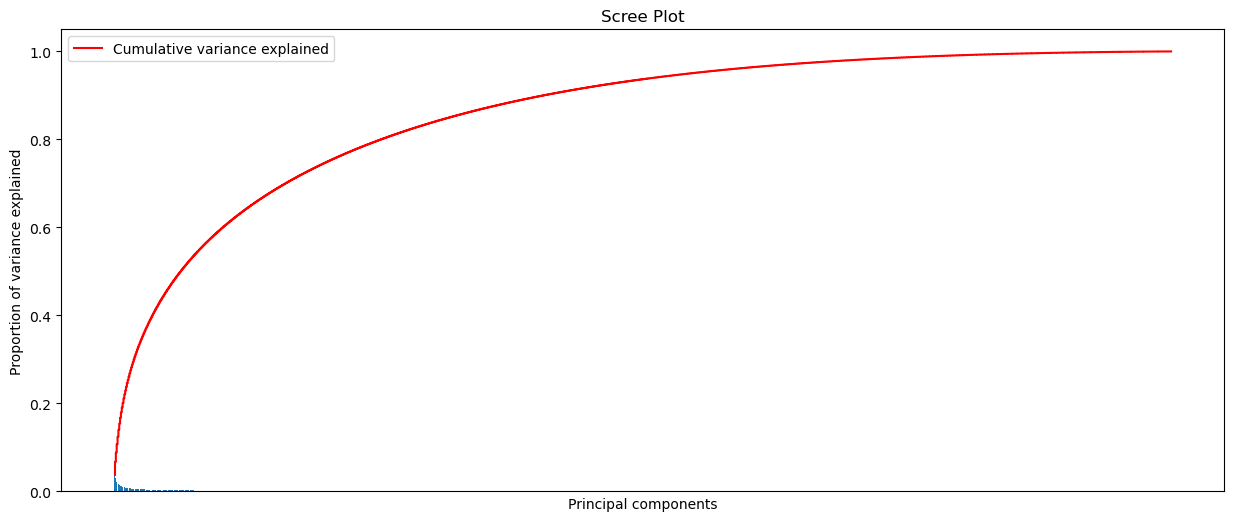

In [24]:
# Figure size
plt.figure(figsize=(15,6))

# Create bar plot
xcor = np.arange(1, len(pve) + 1)  # 1,2,..,n_components
plt.bar(xcor, pve)
plt.xticks(xcor)

# Add cumulative sum
plt.step(xcor + 0.5,np.cumsum(pve),label="Cumulative variance explained",color='red')

# Add labels
plt.xlabel("Principal components")
plt.xticks([])
plt.ylabel("Proportion of variance explained")
plt.title('Scree Plot')
plt.legend()
plt.show()

## 8) Baseline model

Our baseline performance metric will be the percentage of samples correctly predicted if we predict the most frequent class for all samples.

In [25]:
# Import the DummyClassifier class from scikit-learn
from sklearn.dummy import DummyClassifier

# Create a dummy classifier object with 'most_frequent' strategy
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=1)

# Train the dummy classifier on the training/validation data
dummy_clf.fit(X_trainval, ylab_trainval)

# Calculate and print the accuracy score of the dummy classifier on the test data
accuracy_score = dummy_clf.score(X_test, ylab_test)

# Print an informative message about the accuracy score
print("Accuracy score of the dummy classifier on the test data: {:.2%}".format(accuracy_score))

Accuracy score of the dummy classifier on the test data: 28.75%


## 9) k-NN model

Our first machine learning model will be K nearest neighbours (k-NN). We choose a k-NN model because it is relatively simple to implement, but it can also classify data that is not linearly separable in the feature space.

A drawback of the k-NN model is that, with a high number of features (e.g. over 2,000), the distance metric used in k-NN can become irrelevant. Indeed, all samples will tend to have a similar distance to each other in a space with a high number of dimensions.

### Model set-up

In [26]:
# Import necessary modules from scikit-learn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define a pipeline for K-Nearest Neighbors (k-NN) classifier
knn_estimator = Pipeline(
    [
        ("scaler", StandardScaler()),  # Standardize features by removing the mean and scaling to unit variance
        ("knn", KNeighborsClassifier()),  # K-Nearest Neighbors classifier
    ]
)

# Display the parameters of the k-NN classifier
knn_estimator.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()), ('knn', KNeighborsClassifier())],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 5,
 'knn__p': 2,
 'knn__weights': 'uniform'}

### Grid search with cross-validation to find optimal hyper-parameters

We need to find the optimal value for our hyperparameter, the number of neighbours (k). We will select hyperparameter that maximizes the mean accuracy on the validation sets.

In [27]:
# Define the grid of hyperparameters for grid search
grid = {
    "knn__n_neighbors": list(range(1, 30+1)),  # Number of neighbors to consider (1 to 30)
}

# Create a grid search object for KNN classifier
knn_random_search = GridSearchCV(
    knn_estimator,  # Pipeline containing the estimator and preprocessing steps
    cv=5,  # Number of folds for cross-validation
    param_grid=grid,  # Grid of hyperparameters to search over
    return_train_score=True,  # Return training scores
    refit=True,  # Refit the best model on the entire training/validation set
    verbose=True,  # Print progress messages
    n_jobs=-1  # Use all available CPU cores for parallel computation
)

# Perform grid search to find the best hyperparameters
knn_random_search.fit(X_trainval, ylab_trainval)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29, 30]},
             return_train_score=True, verbose=True)

The highest accuracy is achieved with 2 neighbours.

In [28]:
# Best parameters
knn_random_search.best_params_

{'knn__n_neighbors': 2}

In [29]:
# These are the metrics computer during the grid search 
knn_random_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_knn__n_neighbors', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [30]:
# Create a DataFrame to store the results of hyperparameter search for KNN
knn_param_search_results = pd.DataFrame(
    {
        "k": knn_random_search.cv_results_["param_knn__n_neighbors"],  # Number of neighbors (k)
        "mean_tr": knn_random_search.cv_results_["mean_train_score"],  # Mean training score
        "std_tr": knn_random_search.cv_results_["std_train_score"],  # Standard deviation of training score
        "mean_val": knn_random_search.cv_results_["mean_test_score"],  # Mean validation score
        "std_val": knn_random_search.cv_results_["std_test_score"]  # Standard deviation of validation score
    }
)

# Display the top 10 results based on mean validation score
top_10_results = knn_param_search_results.sort_values(by="mean_val", ascending=False)[:10]
top_10_results

k   mean_tr    std_tr  mean_val   std_val
1   2  0.888825  0.010419  0.647454  0.016607
2   3  0.779245  0.009294  0.631454  0.035184
0   1  1.000000  0.000000  0.628228  0.021590
3   4  0.765423  0.007917  0.625015  0.010365
5   6  0.705727  0.009863  0.617841  0.030022
4   5  0.732369  0.010856  0.617828  0.023339
6   7  0.683890  0.013240  0.610638  0.033634
7   8  0.665864  0.013303  0.608225  0.030522
8   9  0.649634  0.016070  0.599415  0.031762
9  10  0.634013  0.014126  0.589796  0.033031

The training score decreases gradually as the number of neighbors (k) increases, starting from a perfect fit at k=1. However, the validation score exhibits diminishing returns with higher complexity (k), indicating potential overfitting, which suggests the model's performance may not benefit significantly from additional neighbors beyond a certain point.

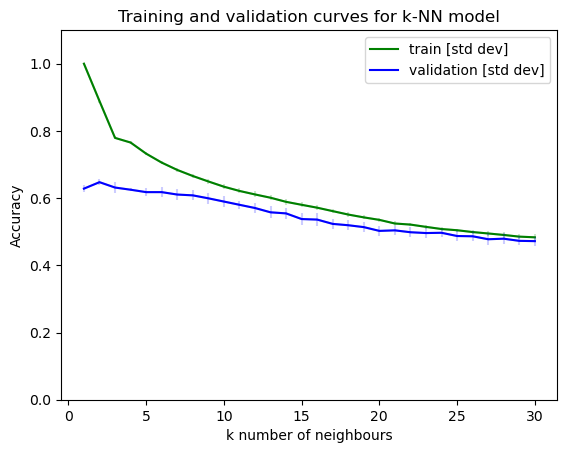

In [31]:
# Plot mean training scores
plt.plot(knn_param_search_results["k"],knn_param_search_results["mean_tr"],label="train [std dev]", color="green")
plt.errorbar(knn_param_search_results["k"],knn_param_search_results["mean_tr"], yerr=knn_param_search_results["std_tr"]*0.5, color="green", alpha=0.2)

# Plot mean validation scores
plt.plot(knn_param_search_results["k"],knn_param_search_results["mean_val"],label="validation [std dev]", color="blue")
plt.errorbar(knn_param_search_results["k"],knn_param_search_results["mean_val"], yerr=knn_param_search_results["std_val"]*0.5, color="blue", alpha=0.2)

#Titles and labels
plt.title("Training and validation curves for k-NN model")
plt.ylabel("Accuracy")
plt.xlabel("k number of neighbours")
plt.ylim(0,1.1)
plt.legend()
plt.show()

### Assess performance on the test set

Finally, we assess the performance of our tuned k-NN model on the testing set, which was set apart at the beginning.

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def get_report(truelabels, predlabels):
    """
    Generates and prints a classification report based on true and predicted labels.

    Parameters:
    truelabels (array-like): True labels.
    predlabels (array-like): Predicted labels.
    """
    print(classification_report(y_true=truelabels, y_pred=predlabels))

def get_confusion_matrix(truelabels, predlabels):
    """
    Plots the confusion matrix based on true and predicted labels.

    Parameters:
    truelabels (array-like): True labels.
    predlabels (array-like): Predicted labels.
    """
    # Get unique labels in the test set
    cm_test_labels = pd.Series(truelabels).value_counts().index
    # Generate confusion matrix display
    disp = ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_true=truelabels, y_pred=predlabels, labels=cm_test_labels),
        display_labels=cm_test_labels
    )
    # Plot confusion matrix
    disp.plot()
    plt.show()

# Get predictions on the test set using the trained model
test_set_predictions = knn_random_search.predict(X_test)

The overall accuracy of the model is 64%, but we can see some variation in how the model performs for different classes.

Overall, the model performs reasonably well across different classes, with particularly strong performance on "Bottle" and "Plastic film" classes, while showing room for improvement, especially on "Can" and "Cup" classes where precision and recall are relatively lower.

In [33]:
get_report(ylab_test, test_set_predictions)

              precision    recall  f1-score   support

      Bottle       0.66      0.83      0.74        88
         Can       0.66      0.46      0.54        46
      Carton       0.61      0.50      0.55        50
         Cup       0.52      0.33      0.41        39
Plastic film       0.65      0.76      0.70        90

    accuracy                           0.64       313
   macro avg       0.62      0.57      0.59       313
weighted avg       0.63      0.64      0.63       313



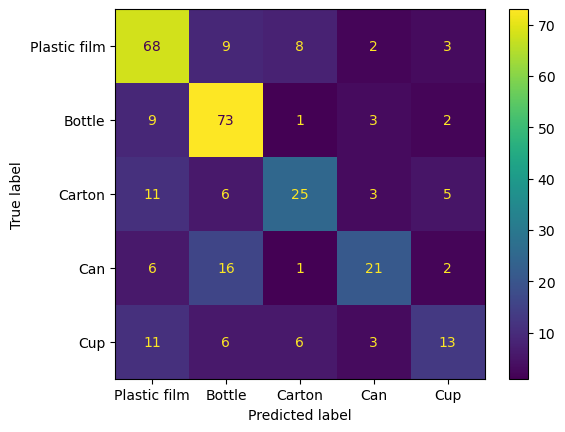

In [34]:
get_confusion_matrix(ylab_test, test_set_predictions)

Finally, we produce a receiver operating characteristic (ROC) curve for this model. Because this is a multiclass problem, we produce a [multiclass ROC curve](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html) by micro-averaging, or aggregating, the contributions from all classes.

These ROC curves will be particularly useful for comparing different models: those models who reach the most top-left point in the ROC curve can produce predictions with a high true positive rate and a low false positive rate.

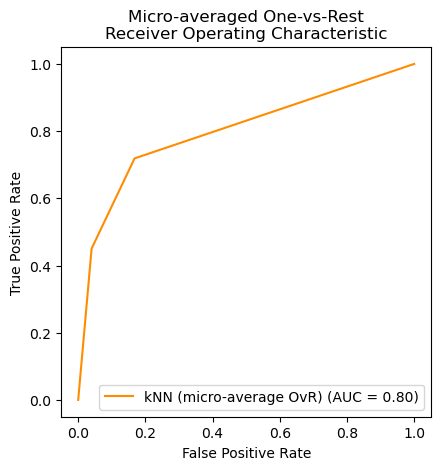

In [35]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

# Fit LabelBinarizer to training labels and transform test labels to one-hot encoded format
label_binarizer = LabelBinarizer().fit(ylab_trainval)
y_onehot_test = label_binarizer.transform(ylab_test)

# Generate ROC curve display using micro-average one-vs-rest strategy
knn_roc = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    knn_random_search.predict_proba(X_test).ravel(),
    name="kNN (micro-average OvR)",
    color="darkorange"
)

# Set plot properties
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

## 10) Logistic model

Having proposed and tuned a k-NN model, we try to classify our samples using a logistic model using the 'one vs. rest' approach. This means that we are performing 5 different logistic regressions, or one for each class. For example, in the regression for class="Bottle" we encode the outcome variable as 1="is bottle" and 0="is not bottle". When it comes to prediction, we predict the class wih the highest predicted likelihood for the positive class.

We include an L2 penalty term, which is controlled by hyper-parameter C and prevents the model coefficients from becoming too large - a sign of overfitting.

The parameter class_weight='balanced' in the logistic regression model assigns weights to each class inversely proportional to their respective frequencies in the training data. This means that classes with fewer instances will be given higher weight, while classes with more instances will be given lower weight, thereby balancing the influence of each class during model training. It helps to mitigate the impact of class imbalance, ensuring that the model does not disproportionately favor the majority class and improving its ability to generalize to minority classes.

### Model set-up

In [36]:
from sklearn.linear_model import LogisticRegression

# Define a pipeline for logistic regression model
logreg_estimator = Pipeline(
    [
        ("scaler", StandardScaler()),  # Standardize features
        ("logreg", LogisticRegression(multi_class='ovr', penalty="l2", class_weight='balanced'))  # Logistic regression model with one-vs-rest strategy, L2 penalty, and balanced class weights
    ]
)

# Display the parameters of the logistic regression estimator
logreg_estimator.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('logreg', LogisticRegression(class_weight='balanced', multi_class='ovr'))],
 'verbose': False,
 'scaler': StandardScaler(),
 'logreg': LogisticRegression(class_weight='balanced', multi_class='ovr'),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'logreg__C': 1.0,
 'logreg__class_weight': 'balanced',
 'logreg__dual': False,
 'logreg__fit_intercept': True,
 'logreg__intercept_scaling': 1,
 'logreg__l1_ratio': None,
 'logreg__max_iter': 100,
 'logreg__multi_class': 'ovr',
 'logreg__n_jobs': None,
 'logreg__penalty': 'l2',
 'logreg__random_state': None,
 'logreg__solver': 'lbfgs',
 'logreg__tol': 0.0001,
 'logreg__verbose': 0,
 'logreg__warm_start': False}

### Grid search with cross-validation to find optimal hyper-parameters

We perform grid search with cross-validation to find the optimal value of C.

In [37]:
from sklearn.model_selection import GridSearchCV

# Define a range of values for the regularization parameter C
C_vals = np.logspace(-4, 6, num=30)

# Define the grid search parameters
grid = {
    "logreg__C": C_vals  # Regularization parameter C for logistic regression
}

# Initialize and fit GridSearchCV to find the best hyperparameters for logistic regression
logistic_gscv = GridSearchCV(
    estimator=logreg_estimator,  # Logistic regression estimator
    param_grid=grid,  # Grid of hyperparameters to search
    cv=5,  # 5-fold cross-validation
    refit=True,  # Refit the best model on the entire training set
    return_train_score=True,  # Return training scores
    verbose=True,  # Print detailed messages
    n_jobs=-1  # Use all available CPU cores for parallel processing
)

# Fit the GridSearchCV object on the training data
logistic_gscv.fit(X_trainval, ylab_trainval)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(class_weight='balanced',
                                                           multi_class='ovr'))]),
             n_jobs=-1,
             param_grid={'logreg__C': array([1.00000000e-04, 2.21221629e-04, 4.89390092e-04, 1.08263673e-03,
       2.39502662e-03, 5.29831691e-03, 1.17210230e-02, 2.59294380e-02,
       5.73615251e-02, 1.26896100e-01, 2.80721620e-01, 6.21016942e-01,
       1.37382380e+00, 3.03919538e+00, 6.72335754e+00, 1.48735211e+01,
       3.29034456e+01, 7.27895384e+01, 1.61026203e+02, 3.56224789e+02,
       7.88046282e+02, 1.74332882e+03, 3.85662042e+03, 8.53167852e+03,
       1.88739182e+04, 4.17531894e+04, 9.23670857e+04, 2.04335972e+05,
       4.52035366e+05, 1.00000000e+06])},
             return_train_score=True, verbose=True)

In [38]:
# Retrieve the best logistic regression estimator from the GridSearchCV results
logistic_gscv.best_estimator_["logreg"]

LogisticRegression(C=0.011721022975334805, class_weight='balanced',
                   multi_class='ovr')

We can see from our grid search with cross validation that the value of C that maximises the validation accuracy is approximately 0.01.

From our validation curve, we can see that with high values of C (meaning less regularization) the model tends to overfit with an accuracy of 100% on the training set but under 80% on the validation set.

In [39]:
# Create a DataFrame to store logistic regression cross-validation results
logreg_results = pd.DataFrame(
    {
        "C": logistic_gscv.cv_results_["param_logreg__C"],  # Regularization parameter C
        "mean_tr": logistic_gscv.cv_results_["mean_train_score"],  # Mean training score
        "std_tr": logistic_gscv.cv_results_["std_train_score"],  # Standard deviation of training scores
        "mean_val": logistic_gscv.cv_results_["mean_test_score"],  # Mean validation score
        "std_val": logistic_gscv.cv_results_["std_test_score"]  # Standard deviation of validation scores
    }
)

# Display the top 5 models based on mean validation score
logreg_results.sort_values(by="mean_val", ascending=False)[:5]

C   mean_tr    std_tr  mean_val   std_val
6  0.011721  0.999199  0.000401  0.772450  0.017634
3  0.001083  0.924479  0.004277  0.767637  0.022964
2  0.000489  0.881010  0.004474  0.767621  0.020636
5  0.005298  0.992588  0.001745  0.766037  0.018567
4  0.002395  0.964144  0.003365  0.765231  0.021641

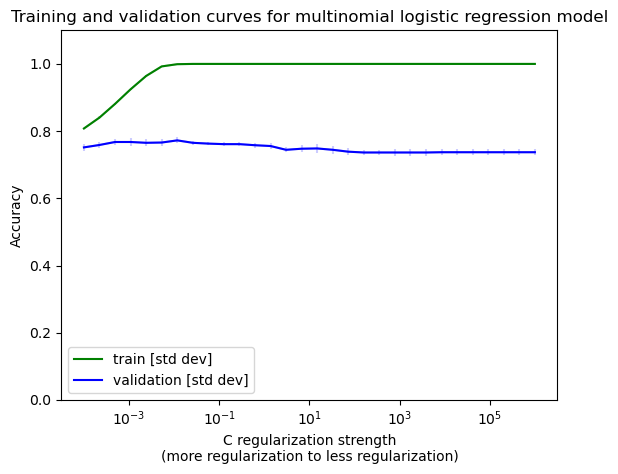

In [40]:
# Plot mean training scores
plt.semilogx(logreg_results["C"],logreg_results["mean_tr"],label="train [std dev]", color="green")
plt.errorbar(logreg_results["C"],logreg_results["mean_tr"], yerr=logreg_results["std_tr"]*0.5, color="green", alpha=0.2)

# Plot mean validation scores
plt.semilogx(logreg_results["C"],logreg_results["mean_val"],label="validation [std dev]", color="blue")
plt.errorbar(logreg_results["C"],logreg_results["mean_val"], yerr=logreg_results["std_val"]*0.5, color="blue", alpha=0.2)

#Titles and labels
plt.title("Training and validation curves for multinomial logistic regression model")
plt.ylabel("Accuracy")
plt.xlabel("C regularization strength\n(more regularization to less regularization)")
plt.ylim(0,1.1)
plt.legend()
plt.show()

### Assess performance on the test set

Now, we can assess the performance on the test set. The model generally performs well across all classes, with varying degrees of precision, recall, and F1-score for each class. "Bottle" and "Plastic film" classes tend to have higher precision, recall, and F1-score values, indicating better performance in correctly identifying instances of these classes. However, the "Carton" class has comparatively lower precision, recall, and F1-score values, suggesting some difficulty in correctly classifying instances belonging to this class.

In [41]:
# Predict classes on the test set
test_set_predictions = logistic_gscv.predict(X_test)

In [42]:
# Get classification report
get_report(ylab_test, test_set_predictions)

              precision    recall  f1-score   support

      Bottle       0.75      0.85      0.80        88
         Can       0.72      0.61      0.66        46
      Carton       0.58      0.66      0.62        50
         Cup       0.70      0.59      0.64        39
Plastic film       0.71      0.67      0.69        90

    accuracy                           0.70       313
   macro avg       0.69      0.68      0.68       313
weighted avg       0.70      0.70      0.70       313



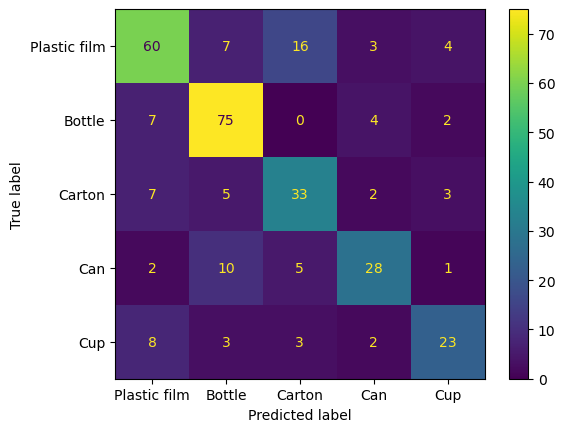

In [43]:
# Get confusion matrix
get_confusion_matrix(ylab_test, test_set_predictions)

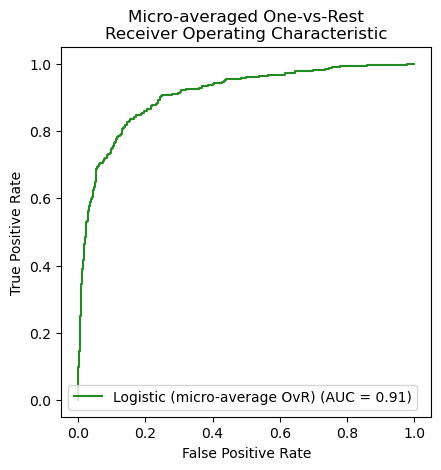

In [44]:
# Plotting ROC curve using RocCurveDisplay
logistic_roc = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),  # True labels in one-hot encoded format
    logistic_gscv.predict_proba(X_test).ravel(),  # Predicted probabilities from the logistic regression model
    name="Logistic (micro-average OvR)",  # Name of the plot
    color="forestgreen"  # Color of the plot
)

# Setting plot properties
plt.axis("square")  # Setting aspect ratio to square
plt.xlabel("False Positive Rate")  # X-axis label
plt.ylabel("True Positive Rate")  # Y-axis label
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")  # Title of the plot
plt.legend()  # Displaying legend
plt.show()  # Showing the plot

## 11) Model comparison

Finally we can compare the performance of our two models and our baseline.

In terms of accuracy, both models perform better than the baseline (29%). Looking at the accuracy and the ROC curves, we can see that the logistic model (70% accurate) out-performs the k-NN model (64% accurate) on the test set.

In [45]:
# Creating a dictionary to store the model names and their corresponding test accuracies
final_comparison = {
    'k-NN': [knn_random_search.score(X_test, ylab_test)],  # Accuracy score for kNN model
    'Logistic regression': [logistic_gscv.score(X_test, ylab_test)],  # Accuracy score for logistic regression model
    'Baseline (most frequent)': [dummy_clf.score(X_test, ylab_test)]}  # Accuracy score for the baseline model

# Converting the dictionary to a DataFrame, transposing it, and setting the index as "accuracy"
final_comparison = pd.DataFrame(final_comparison, index=["accuracy"]).transpose()

# Sorting the DataFrame by accuracy score in ascending order
final_comparison.sort_values(by="accuracy", inplace=True)

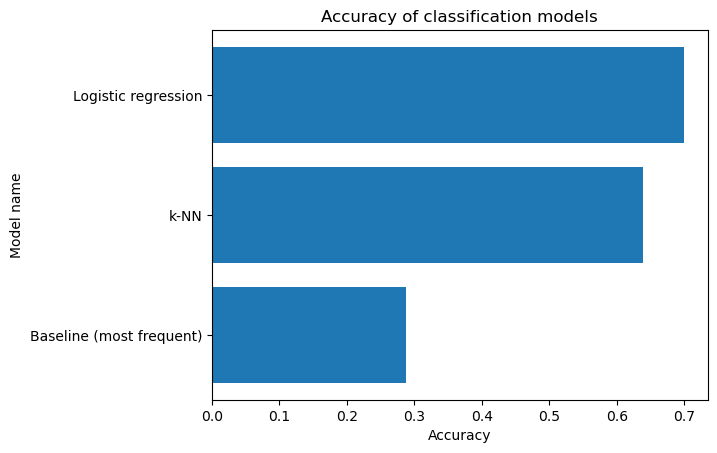

In [47]:
# Creating a horizontal bar plot to visualize the accuracy of classification models
plt.barh(width=final_comparison.accuracy, y=final_comparison.index)

# Adding title and axis labels
plt.title("Accuracy of classification models")
plt.ylabel("Model name")
plt.xlabel("Accuracy")

# Displaying the plot
plt.show()

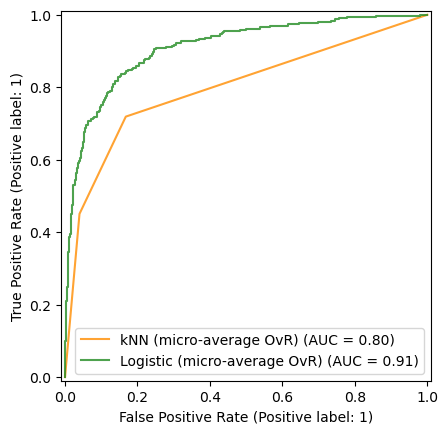

In [48]:
# Get the current Axes instance
ax = plt.gca()

# Plotting the ROC curves for kNN and logistic regression models on the same Axes
knn_roc.plot(ax=ax, alpha=0.8, color="darkorange")
logistic_roc.plot(ax=ax, alpha=0.8, color="forestgreen")

# Display the plot
plt.show()